In [4]:
import numpy as np
import pandas as pd
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pywt

# Lunar data


In [2]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]

print(len(cat))
cat.head()

76


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type,arrival_time,arrival_time_rel
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq,1970-01-19 20:25:00,73500.0
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq,1970-03-25 03:32:00,12720.0
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq,1970-03-26 20:17:00,73020.0
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq,1970-04-25 01:14:00,4440.0
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq,1970-04-26 14:29:00,52140.0


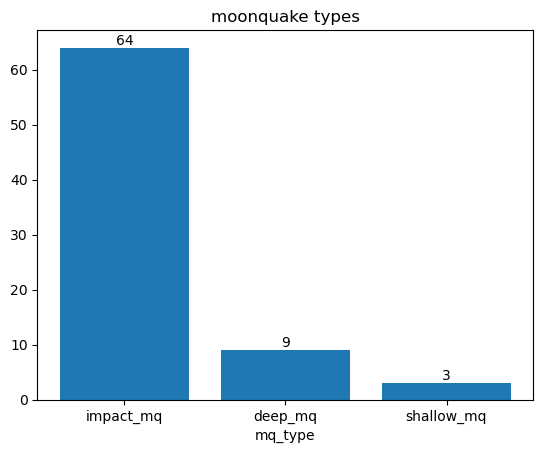

In [3]:
mq_type_counts = cat["mq_type"].value_counts()
bars = plt.bar(mq_type_counts.index, mq_type_counts.values)
plt.xlabel("mq_type")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
    )

plt.title("moonquake types")
plt.show()


File name - `xa.s12.00.mhz.1970-01-19HR00_evid00002`

via https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/document/apollo_pse_description.pdf

1. "xa": network id.
2. "s12": station id. Apollo 12 seismic station.
3. "00": location code.`00` for peaked mode operation and `01` for flat mode operation
4. "mhz": channel id - can be mhz, mh1,mh2, shz, att.
5. "1970-01-19": date of the recording (January 19, 1970).
6. "HR00": File revision number
7. "evid00002": event id?


In [4]:
fname = "xa.s12.00.mhz.1970-01-19HR00_evid00002"

In [7]:
train_dir = base_dir / "data/lunar/training/data/"
test_dir = base_dir / "data/lunar/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))

training data:  76
test data:  96


In [8]:
print("train data")
# for evid00029, one of the files says HR02 instead of HR00 (as in the catalog)
for f in train_filenames:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

print("test data")
for f in test_filenames:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

train data
Error reading file ../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed: [Errno 2] No such file or directory: '../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed'
test data


In [10]:
for i, f in enumerate(train_filenames):
    if "evid00029" in str(f):
        train_filenames[i] = Path(
            "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
        )
train_streams = []
for f in train_filenames:
    try:
        train_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

In [47]:
train_streams[0][0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-01-19T00:00:00.665000Z
         endtime: 1970-01-20T00:00:02.778208Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572415
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [12]:
# D means "Data of undetermined quality", and is the case for all waveforms here.
print(
    set(
        [train_streams[i][0].stats.mseed.dataquality for i in range(len(train_streams))]
    )
)
print(set([train_streams[i][0].stats.sampling_rate for i in range(len(train_streams))]))
# same for test data
print(
    set([test_streams[i][0].stats.mseed.dataquality for i in range(len(test_streams))])
)
print(set([test_streams[i][0].stats.sampling_rate for i in range(len(test_streams))]))

{'D'}
{6.625}
{'D'}
{6.625}


{'impact_mq': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'deep_mq': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'shallow_mq': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)}


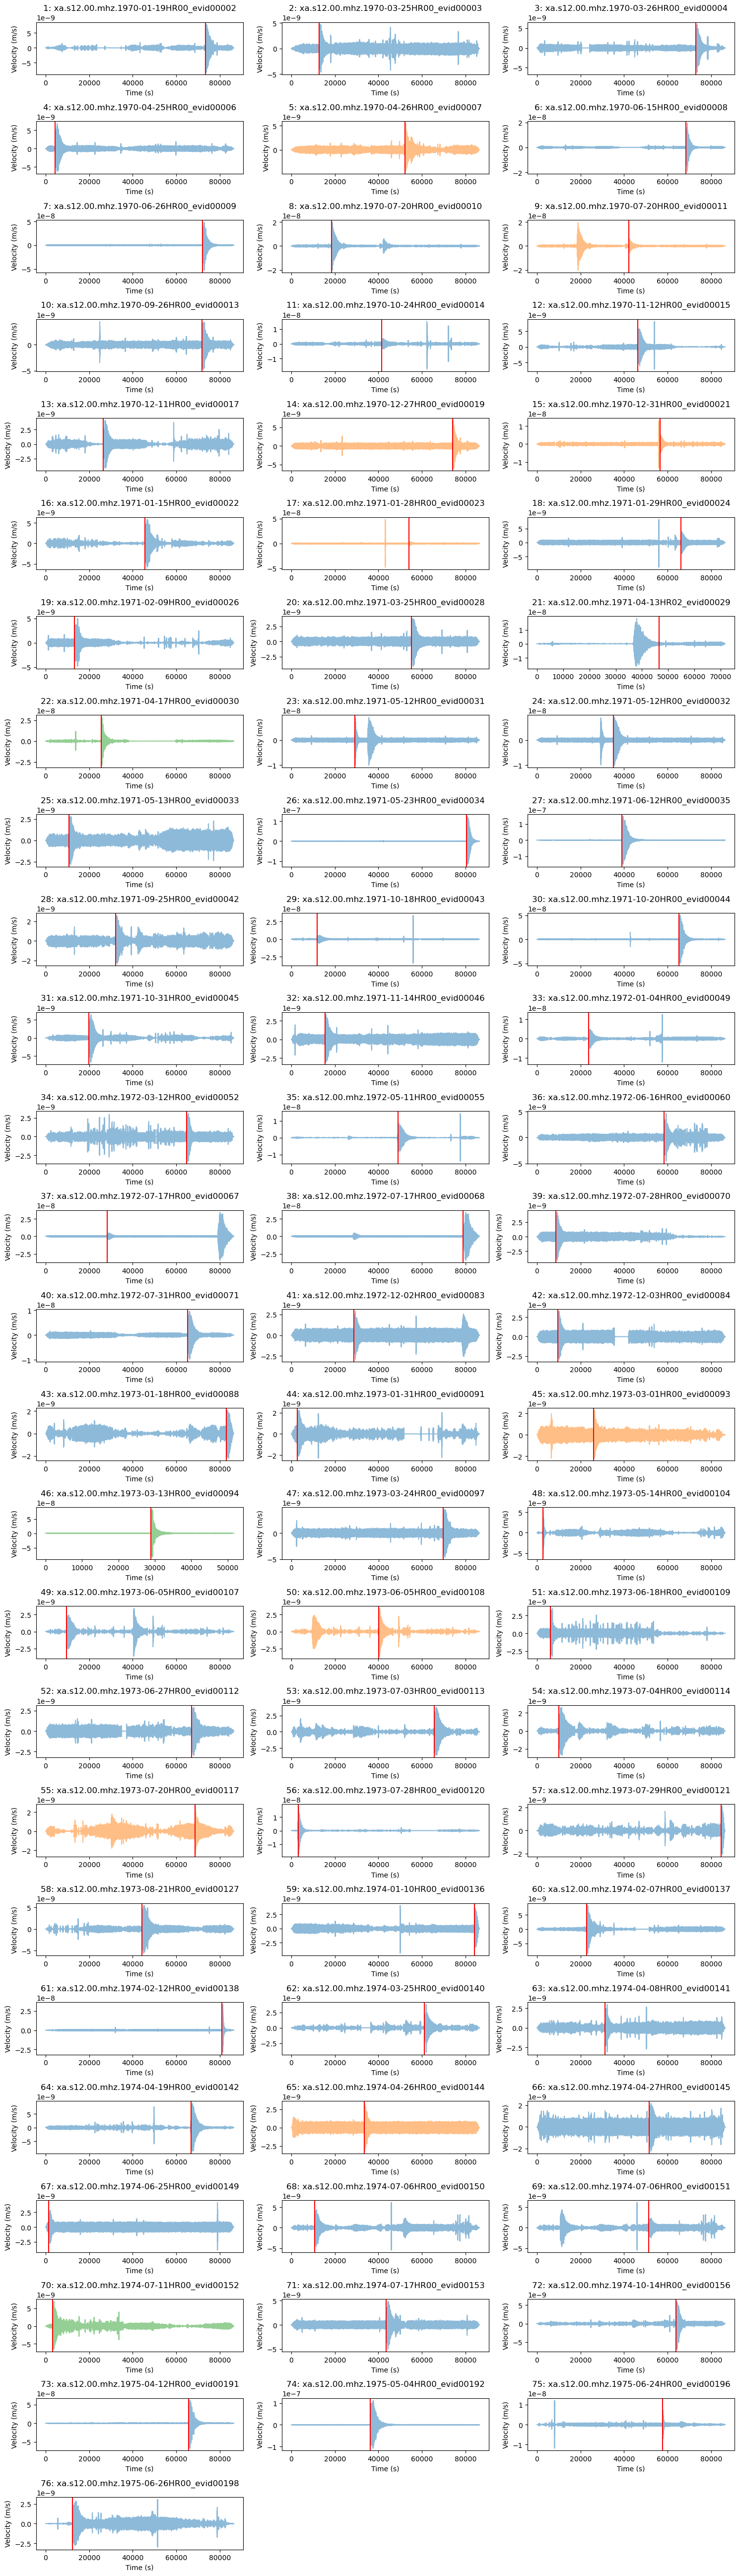

In [16]:
def get_time_speed(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data
    return tr_times, tr_data


nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

unique_mq_types = cat["mq_type"].nunique()
color_map = plt.colormaps["tab10"]
color_dict = {mq: color_map(i) for i, mq in enumerate(cat["mq_type"].unique())}
print(color_dict)
for i, stream in enumerate(train_streams):
    x, y = get_time_speed(stream)

    mq_type = cat.loc[i, "mq_type"]
    color = color_dict[mq_type]

    axs[i].plot(x, y, color=color, alpha=0.5)
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

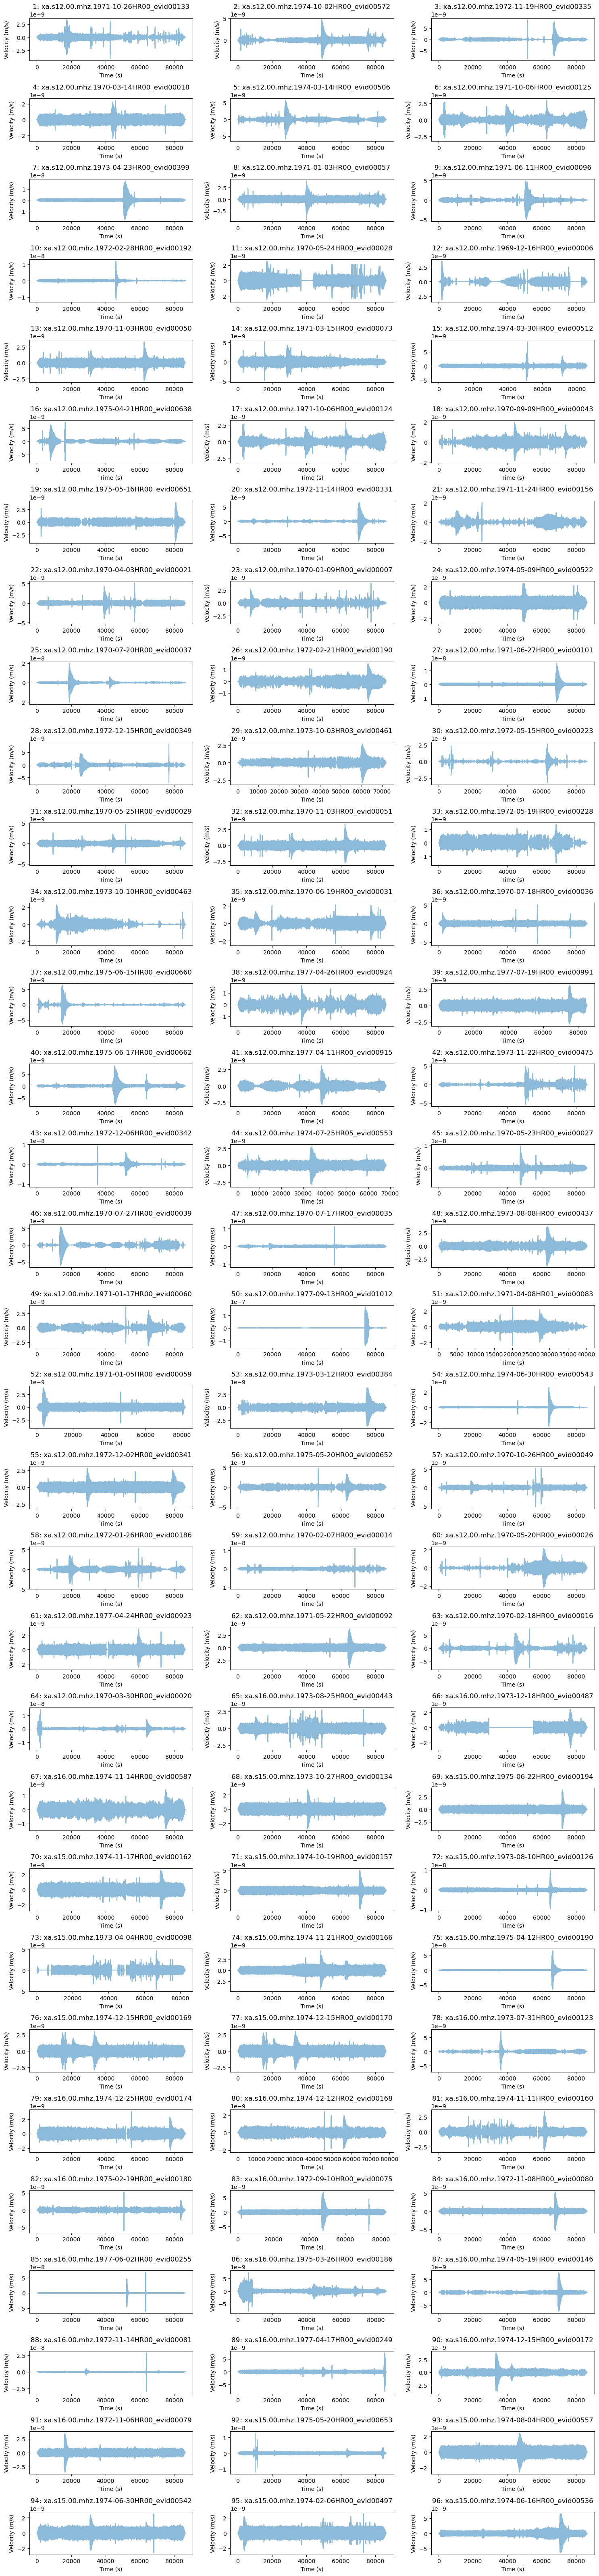

In [19]:
## plot test data

nrows = (len(test_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(test_streams):
    x, y = get_time_speed(stream)

    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

# Mars data


In [21]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = (
    base_dir / "data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"
)
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]

print(len(cat))
cat.head()

2


,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,arrival_time,arrival_time_rel
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005,2022-02-03 08:08:27,507.0
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006,2022-01-02 04:35:30,2130.0


File name = `XB.ELYSE.02.BHV.2022-01-02HR04_evid0006`

via https://pds-geosciences.wustl.edu/insight/urn-nasa-pds-insight_seis/readme.txt

1. `XB`: network id.
2. `ELYSE`: station id.
3. `02`: location code.
4. `BHV`: channel id
5. `2022-01-02`: date of the recording (January 2, 2022).
6. `HR04`: File revision number
7. `evid0006`: event id?


In [28]:
"frefre.csv"[:-4]

'frefre'

In [30]:
train_dir = base_dir / "data/mars/training/data/"
test_dir = base_dir / "data/mars/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"{x[:-4]}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))

train_streams = []
for f in train_filenames:
    try:
        train_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

training data:  2
test data:  9


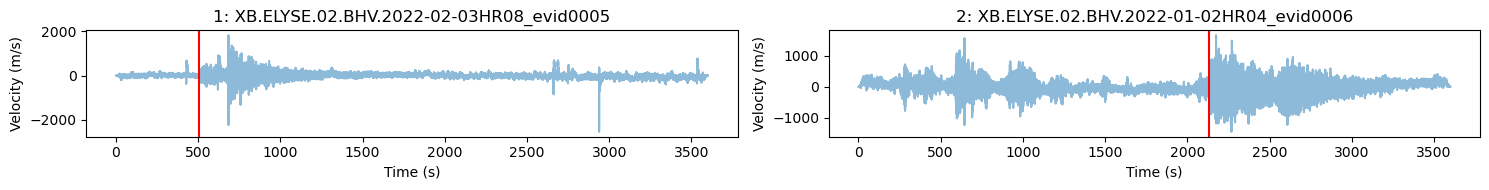

In [38]:
# plot train streams

nrows = (len(train_streams)) // 2
fig, axs = plt.subplots(nrows, 2, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(train_streams):
    x, y = get_time_speed(stream)
    axs[i].plot(x, y, alpha=0.5)
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

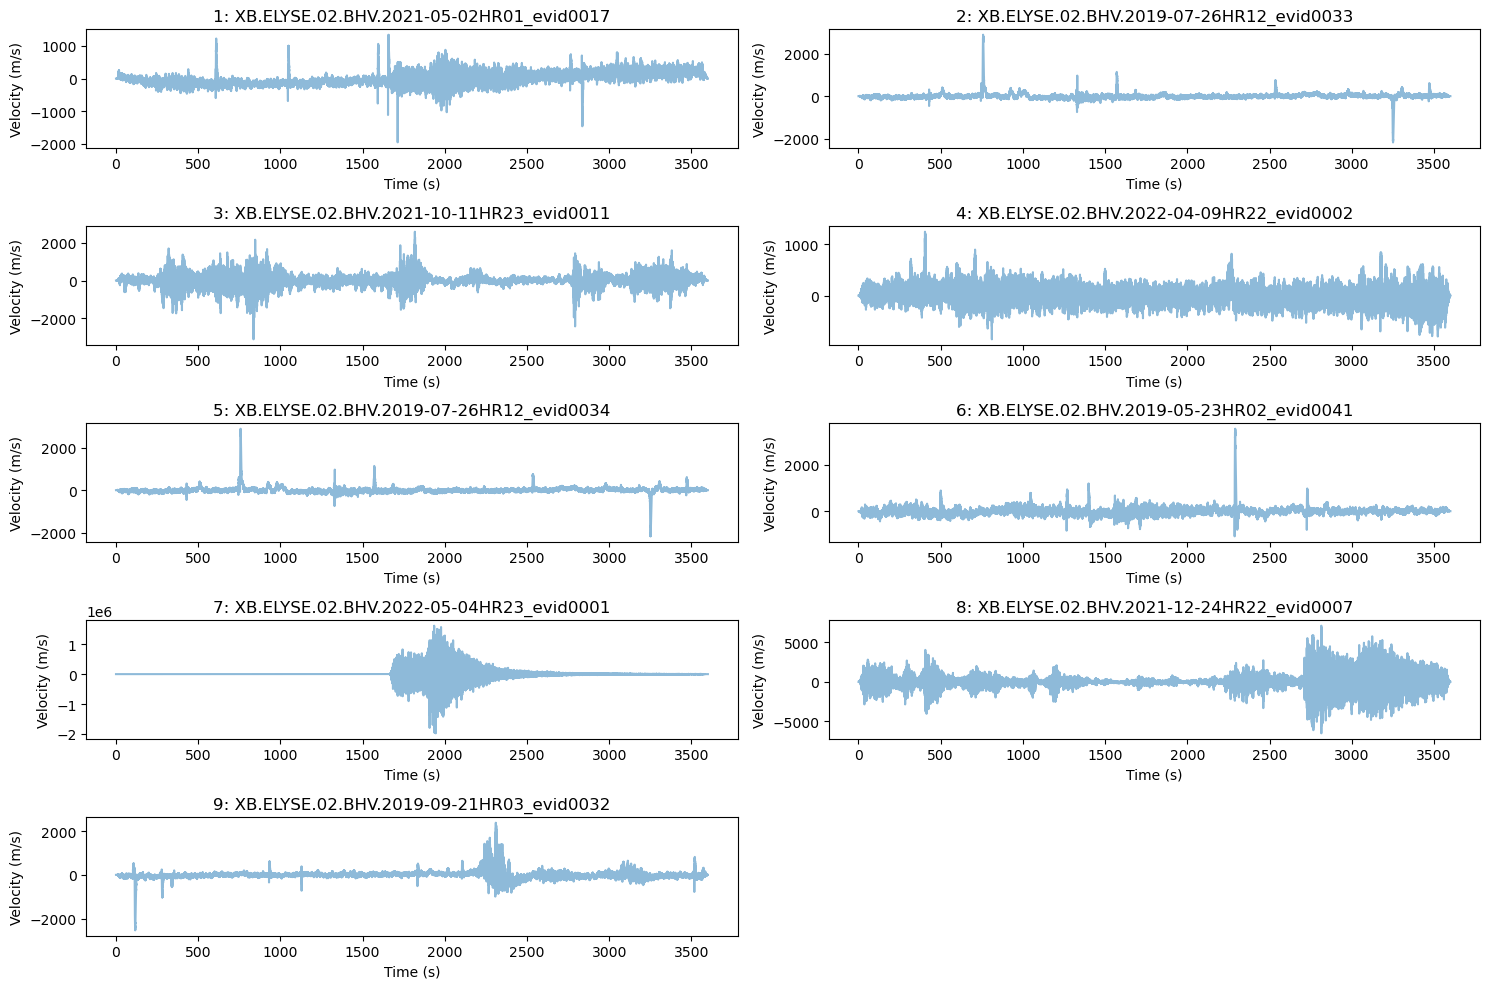

In [37]:
# plot test streams

nrows = (len(test_streams) + 2) // 2
fig, axs = plt.subplots(nrows, 2, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(test_streams):
    x, y = get_time_speed(stream)
    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()

# Time frequency analysis


In [5]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]

train_dir = base_dir / "data/lunar/training/data/"
test_dir = base_dir / "data/lunar/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))

for i, f in enumerate(train_filenames):
    if "evid00029" in str(f):
        train_filenames[i] = Path(
            "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
        )
train_streams = []
for f in train_filenames:
    try:
        train_streams.append(obspy.read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(obspy.read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

training data:  76
test data:  96


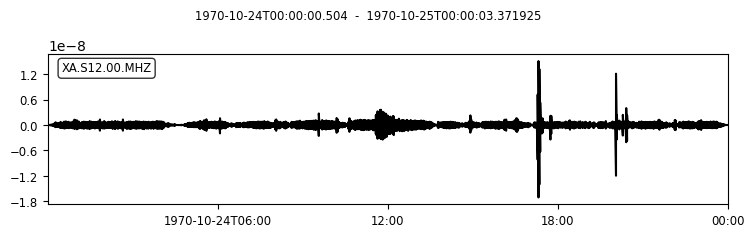

In [39]:
stream = train_streams[10]
stream[0].plot()
plt.show()

In [40]:
# Assuming your signal and sampling rate
signal = stream[0].data
fs = stream[0].stats.sampling_rate


wavelet = "cmor1.5-1.0"
lower_limit = 1e-2
upper_limit = 1


print(f"Frequency limits: {lower_limit:.2f} Hz to {upper_limit:.2f} Hz")

scales = pywt.central_frequency(wavelet) / np.logspace(
    np.log10(upper_limit), np.log10(lower_limit), num=130
)

WT, freqs = pywt.cwt(signal, scales, wavelet)

Frequency limits: 0.01 Hz to 1.00 Hz


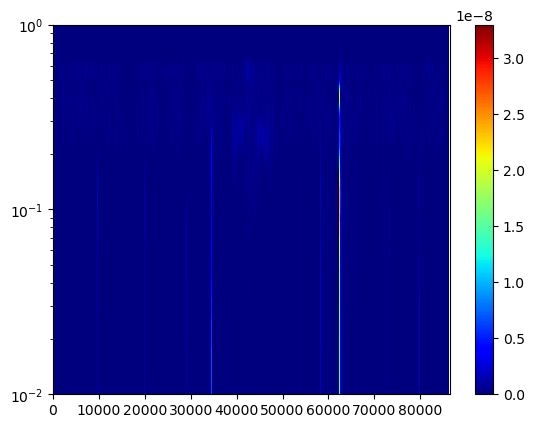

In [41]:
time = np.arange(len(signal)) / fs
plt.imshow(
    np.abs(WT),
    extent=[time.min(), time.max(), freqs.min(), freqs.max()],
    aspect="auto",
    interpolation="nearest",
    cmap="jet",
)
plt.colorbar()
plt.yscale("log")
# plt.gca().invert_yaxis()